In [ ]:
!pip install vaderSentiment scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
# Initialize VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

In [23]:
vader.lexicon.update({
    "hilarious": 3.0,
    "lmao": 2.5,
    "rofl": 3.0,
    "meh": -1.0,
    "awful": -2.0,
    "punny": 2.5,
    "cringe": -2.0,
    "genius": 2.0,
    "iconic": 2.5,
    "deadpan": -0.5,
    "lol": 2.5,
    "ugh": -2.0,
    "literally": -1.0,
    "totally": -1.0,
    "fine": 0.0,
    "great!": 0.2,
    "meh...": -0.5,
    "soooo": 1.5
})

In [22]:
def sentiment_with_sarcasm_adjustment(text):
    scores = vader.polarity_scores(text)

    # Adjust for sarcasm
    if "!" in text and scores['compound'] > 0:
        scores['compound'] += 0.1
    if "..." in text:
        scores['compound'] -= 0.1
    if "soooo" in text.lower() or "literally" in text.lower():
        scores['compound'] *= 0.8

    return scores


In [24]:
df=pd.read_csv('/content/df_jokes_final_category.csv')

In [25]:
sentiment_scores = df['merged_text'].apply(sentiment_with_sarcasm_adjustment)
df['pos'] = sentiment_scores.apply(lambda x: x['pos'])
df['neg'] = sentiment_scores.apply(lambda x: x['neg'])
df['neu'] = sentiment_scores.apply(lambda x: x['neu'])
df['compound'] = sentiment_scores.apply(lambda x: x['compound'])

In [26]:
def derive_final_sentiment(row, compound_thresh=0.05):
    if row['compound'] > compound_thresh:
        return "positive"
    elif row['compound'] < -compound_thresh:
        return "negative"
    else:
        if row['pos'] > row['neg']:
            return "positive"
        elif row['neg'] > row['pos']:
            return "negative"
        else:
            return "neutral"

df['final_sentiment'] = df.apply(derive_final_sentiment, axis=1)

In [27]:
df.head()

,merged_text,final_category,pos,neg,neu,compound,final_sentiment
0,I am soooo glad I'm not circumcised! My corona...,adult,0.292,0.000,0.708,0.65568,positive
1,Did you know Google now has a platform for rec...,pun,0.000,0.000,1.000,0.00000,neutral
2,What is the difference between my wife and my ...,dark humor,0.000,0.122,0.878,-0.49390,negative
3,What did the French man say to the attractive ...,pun,0.225,0.000,0.775,0.34040,positive
4,"Yo Mama Yo momma's so fat, that when she went ...",pun,0.000,0.158,0.842,-0.45880,negative


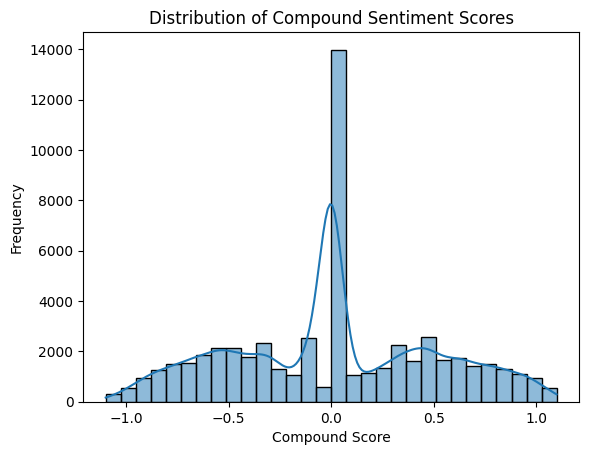

In [34]:
# Visualize Compound Score Distribution
sns.histplot(df['compound'], kde=True, bins=30)
plt.title("Distribution of Compound Sentiment Scores")
plt.xlabel("Compound Score")
plt.ylabel("Frequency")
plt.show()

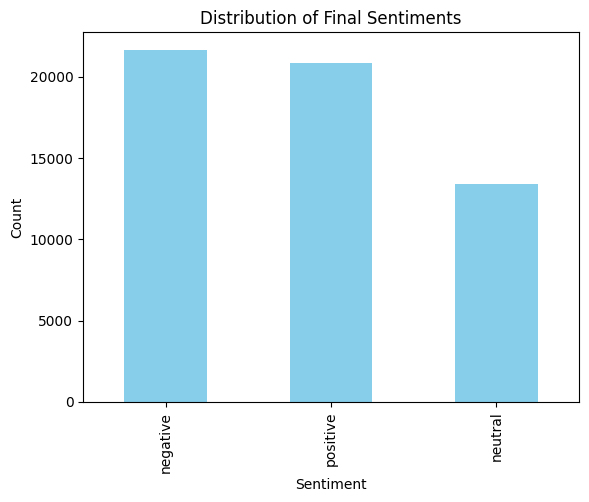

In [35]:
df['final_sentiment'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribution of Final Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

<ipython-input-38-114fff333305>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='final_sentiment', y='pos', data=df, palette="Blues", width=0.6)


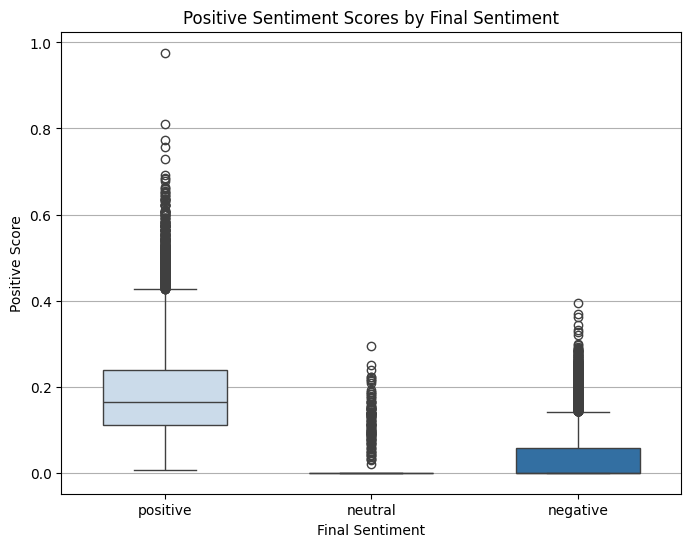

<ipython-input-38-114fff333305>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='final_sentiment', y='neg', data=df, palette="Reds", width=0.6)


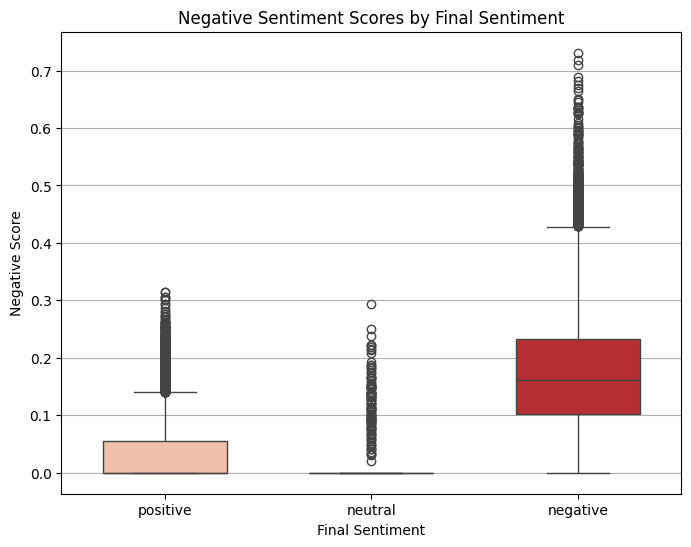

<ipython-input-38-114fff333305>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='final_sentiment', y='neu', data=df, palette="Greens", width=0.6)


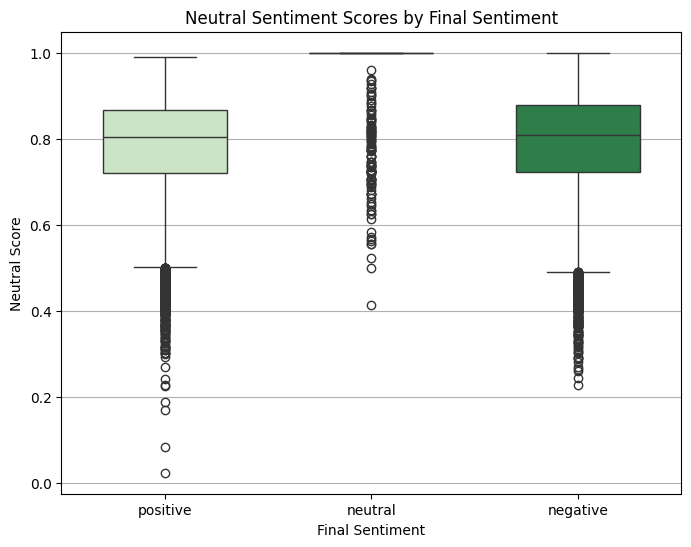

In [38]:
# Boxplot for Positive Sentiment Scores
plt.figure(figsize=(8, 6))
sns.boxplot(x='final_sentiment', y='pos', data=df, palette="Blues", width=0.6)
plt.title("Positive Sentiment Scores by Final Sentiment")
plt.xlabel("Final Sentiment")
plt.ylabel("Positive Score")
plt.grid(axis='y')
plt.show()

# Boxplot for Negative Sentiment Scores
plt.figure(figsize=(8, 6))
sns.boxplot(x='final_sentiment', y='neg', data=df, palette="Reds", width=0.6)
plt.title("Negative Sentiment Scores by Final Sentiment")
plt.xlabel("Final Sentiment")
plt.ylabel("Negative Score")
plt.grid(axis='y')
plt.show()

# Boxplot for Neutral Sentiment Scores
plt.figure(figsize=(8, 6))
sns.boxplot(x='final_sentiment', y='neu', data=df, palette="Greens", width=0.6)
plt.title("Neutral Sentiment Scores by Final Sentiment")
plt.xlabel("Final Sentiment")
plt.ylabel("Neutral Score")
plt.grid(axis='y')
plt.show()


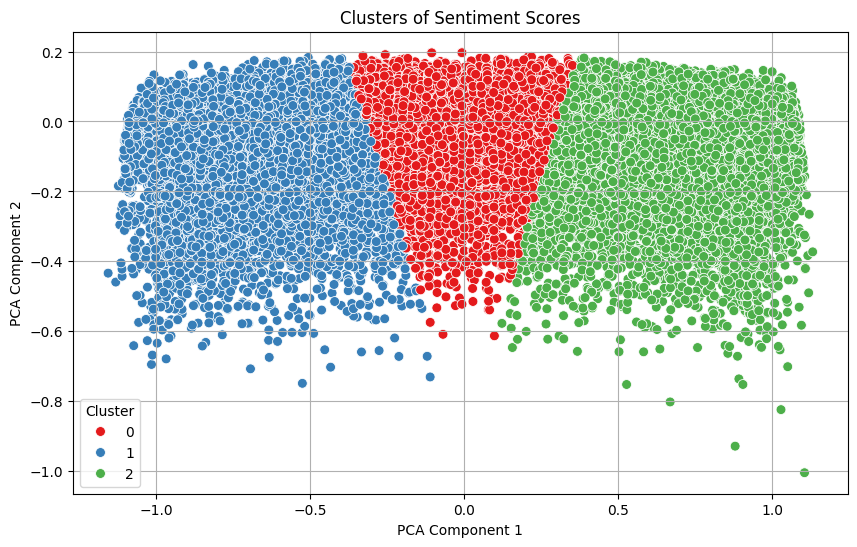

In [37]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Perform KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['pos', 'neg', 'neu', 'compound']])


pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df[['pos', 'neg', 'neu', 'compound']])

# Add PCA-reduced dimensions to the DataFrame
df['pca_x'] = reduced_data[:, 0]
df['pca_y'] = reduced_data[:, 1]


plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca_x', y='pca_y', hue='cluster', data=df, palette='Set1', s=50)
plt.title("Clusters of Sentiment Scores")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


### **Sentiment Analysis Workflow and Insights**

#### **Workflow**
1. **VADER Initialization and Lexicon Update**:
   - The `SentimentIntensityAnalyzer` was initialized, and the lexicon was updated with humor-specific terms:

   - Adjustments for sarcasm were added:
     - Increased sentiment for emphatic punctuation (`!`) and reduced sentiment for ellipses (`...`).

2. **Sarcasm-Adjusted Sentiment Scoring**:
   - A custom function was implemented to adjust VADER scores based on sarcasm and exaggeration.
   - Sentiment scores (`pos`, `neg`, `neu`, `compound`) were extracted for each joke.

3. **Final Sentiment Derivation**:
   - The `final_sentiment` column was derived based on the compound score:
     - **Positive** if the compound score was above `0.05`.
     - **Negative** if below `-0.05`.
     - **Neutral** otherwise, with ties broken using `pos` and `neg` scores.


5. **Visualizations**:
   - **Compound Score Distribution**: Histogram to analyze sentiment polarity.
   - **Sentiment Scores by Final Sentiment**: Boxplots of `pos`, `neg`, and `neu` scores for each sentiment class.
   - **Clusters of Sentiment Scores**: Scatter plot of PCA-reduced sentiment scores, with clusters labeled.

#### **Insights from Visualizations**
1. **Compound Score Distribution**:
   - A bell-shaped distribution peaks at `0`, indicating a prevalence of neutral jokes.
   - Strongly positive and negative jokes appear as tails in the distribution.

2. **Positive Sentiment Scores**:
   - Jokes classified as "positive" have consistently higher positive scores.
   - This highlights the effectiveness of lexicon updates and sarcasm adjustments.

3. **Negative Sentiment Scores**:
   - "Negative" jokes exhibit the highest negative scores compared to "neutral" and "positive" jokes, confirming the validity of score derivations.

4. **Neutral Sentiment Scores**:
   - "Neutral" jokes dominate in `neu` scores, effectively separating from positive and negative jokes.

5. **Clusters of Sentiment Scores**:
   - Three well-separated clusters corresponding to "positive," "neutral," and "negative" sentiments were observed, indicating the robustness of the sentiment scoring mechanism.



### **Conclusion**
The sentiment analysis system effectively classifies jokes into "positive," "neutral," and "negative" sentiments.